# Examine Log-Mel spectrogram

waveform sample points: 154350
sample rate: 22050
Duration: 7.0


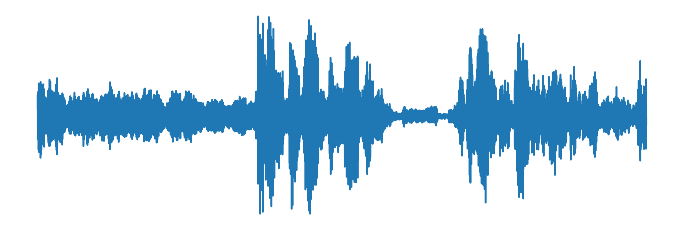

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

import numpy as np

y, sr = librosa.load('../PANN/resources/R9_ZSCveAHg_7s.wav')

print("waveform sample points: {}".format(len(y)))
print("sample rate: {}".format(sr))
print("Duration: {}".format(len(y) / sr))

plt.figure(figsize=(12, 4))
plt.plot(y)
plt.axis('off')
# plt.title('Signal');
# plt.xlabel('Time (samples)');
# plt.ylabel('Amplitude');

(-0.011609977324263039, 7.000816326530613, -5.38330078125, 11030.38330078125)

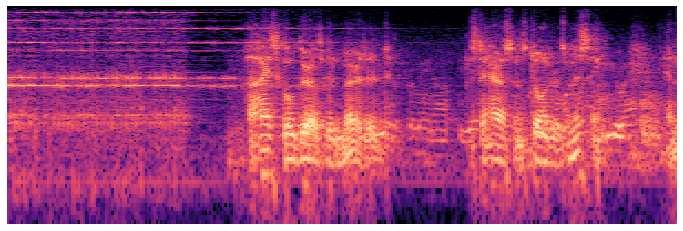

In [7]:
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)

plt.figure(figsize=(12, 4))

librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');

# plt.plot(y)
plt.axis('off')

# plt.colorbar(format='%+2.0f dB');
# plt.title('Spectrogram');

(-0.011609977324263039,
 3.4946031746031743,
 -13.099893564346209,
 11171.94933124797)

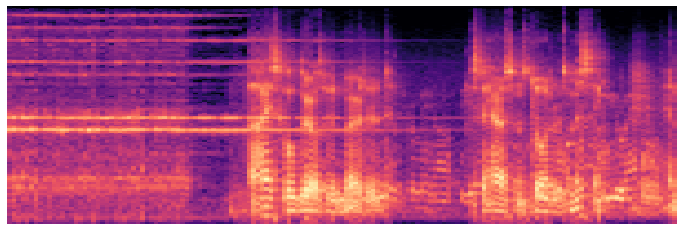

In [9]:
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

plt.figure(figsize=(12, 4))

librosa.display.specshow(mel_spect, y_axis='mel', x_axis='time')
plt.axis('off')

# plt.title('Mel Spectrogram');
# plt.colorbar(format='%+2.0f dB');

# Get frequency distribution

See https://zenodo.org/record/1226427#.YnWZsYfMKbh. The distribution of the central frequency of birdcalls are distributed over 2kHz.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [35]:
FOLDER = "C:/Users/dhu/Downloads"
filenames = [
    "BirdVox-70k_unit01",
    "BirdVox-70k_unit02", 
    "BirdVox-70k_unit03", 
    "BirdVox-70k_unit05", 
    "BirdVox-70k_unit07", 
    "BirdVox-70k_unit10", 
]

freqs_all = np.array([])
for filename in filenames:
    full_filename = "{}/{}.hdf5".format(FOLDER, filename)
    
    # open the file as 'f'
    with h5py.File(full_filename, 'r') as f:
        dset = f["waveforms"]
        keys = dset.keys()
        key_arr = np.array([int(key.split("_")[2]) for key in keys])
        print(key_arr.shape)
        freqs_all = np.concatenate([freqs_all, key_arr])

arr = np.array(freqs_all)
print(arr.shape)


(5852,)
(9460,)
(18226,)
(10528,)
(13060,)
(13678,)
(70804,)


In [36]:
print(np.array(arr == 0).sum())

35402


In [42]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.models.tools import HoverTool
from bokeh.palettes import BuGn4
from bokeh.plotting import figure, output_notebook, show
from bokeh.transform import cumsum

In [43]:
new_df = pd.DataFrame(
    arr[arr > 0], columns=["Frequency"]
)

In [ ]:
source = ColumnDataSource(new_df)
tooltips = [
    ("Frequency", "@Frequency")
]

v = figure(plot_width = 650, plot_height = 600, x_range = new_df.Frequency.values, tooltips = tooltips, title = "Distribution of chirp frequency")
v.vbar("Frequency", bottom = "recordings", source = source, width = 0.75, color = "steelblue", alpha = 0.6)

v.xaxis.axis_label = "Frequency"
v.yaxis.axis_label = "Count"

show(v)

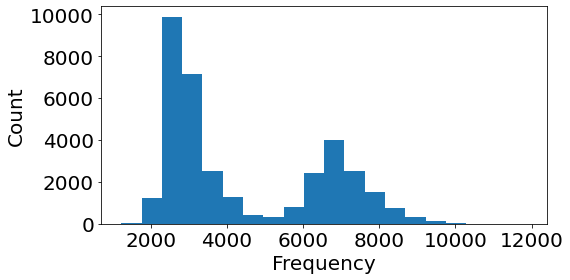

In [41]:
plt.figure(figsize=[8, 4])
plt.hist(arr[arr > 0], bins=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Frequency", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.show()


In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import argparse
import csv
import os
import glob
import datetime
import time
import logging
import h5py
import librosa

from tqdm.notebook import tqdm

from utilities.utils import (create_folder, create_logging, read_metadata, pad_or_truncate, float32_to_int16)

In [12]:
DATA_FOLDER = "C:/Users/dhu/Downloads/birdsong-recognition"

TRAIN_METADATA_PATH = os.path.join(DATA_FOLDER, "train.csv")
WAV_PATH = os.path.join(DATA_FOLDER, "dataset_wav/")
HDF5_PATH = os.path.join(DATA_FOLDER, "train_mini.hdf5")

meta_dict = read_metadata(TRAIN_METADATA_PATH)

In [13]:
def pack_waveforms_to_hdf5(audios_dir, csv_path, waveforms_hdf5_path, sample_rate, clip_length, starting_point=0):
    """Pack waveform and target of several audio clips to a single hdf5 file. 
    This can speed up loading and training.
    """
    logs_dir = '_logs/pack_waveforms_to_hdf5/mini_{}'.format(os.path.basename(csv_path).split(".")[0])

    create_folder(logs_dir)
    create_logging(logs_dir, filemode='w')
    create_folder(os.path.dirname(waveforms_hdf5_path))

    logging.info('Write logs to {}'.format(logs_dir))
    
    meta_dict = read_metadata(csv_path)

    audios_num = len(meta_dict['audio_name'])
    clip_samples = clip_length * sample_rate

    # Pack waveform to hdf5
    total_time = time.time()

    with h5py.File(waveforms_hdf5_path, 'w') as hf:
        hf.create_dataset('audio_name', shape=((audios_num,)), dtype='S20')
        hf.create_dataset('waveform', shape=((audios_num, clip_samples)), dtype=np.float32)
        # hf.create_dataset('target', shape=((audios_num,)), dtype=np.int16)
        hf.attrs.create('sample_rate', data=sample_rate, dtype=np.int32)

        hf['target'] = meta_dict['target']
        all_classes = meta_dict["bird_codes"][meta_dict['target']]

        # Pack waveform & target of several audio clips to a single hdf5 file
        for n in range(starting_point, 100):
            audio_path = os.path.join(audios_dir, all_classes[n], meta_dict['audio_name'][n])

            if os.path.isfile(audio_path):
                logging.info('{} {}'.format(n, audio_path))
                (audio, _) = librosa.core.load(audio_path, sr=sample_rate, mono=True)
                audio = pad_or_truncate(audio, clip_samples)

                hf['audio_name'][n] = meta_dict['audio_name'][n].encode()
                hf['waveform'][n] = audio
            else:
                logging.info('{} File does not exist! {}'.format(n, audio_path))

    logging.info('Write to {}'.format(waveforms_hdf5_path))
    logging.info('Pack hdf5 time: {:.3f}'.format(time.time() - total_time))

pack_waveforms_to_hdf5(WAV_PATH, TRAIN_METADATA_PATH, HDF5_PATH, sample_rate=32000, clip_length=10)

root        : INFO     Write logs to _logs/pack_waveforms_to_hdf5/mini_train
root        : INFO     0 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC134874.wav
root        : INFO     1 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135454.wav
root        : INFO     2 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135455.wav
root        : INFO     3 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135456.wav
root        : INFO     4 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135457.wav
root        : INFO     5 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135459.wav
root        : INFO     6 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135460.wav
root        : INFO     7 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135883.wav
root        : INFO     8 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC137570.wav
root        : 

In [8]:
import pandas as pd
import numpy as np
labels = pd.read_csv("train_new.csv")

In [11]:
np.unique(pd.read_csv("train_new.csv").loc[:4999, "ebird_code"])

array(['aldfly', 'amecro', 'amegfi', 'amepip', 'amered', 'amerob',
       'annhum', 'astfly', 'balori', 'banswa', 'barswa', 'bewwre',
       'bkbwar', 'bkcchi', 'bkhgro', 'bkpwar', 'blkpho', 'blugrb1',
       'blujay', 'bnhcow', 'boboli', 'brdowl', 'brespa', 'brncre',
       'brnthr', 'btnwar', 'buggna', 'buhvir', 'bulori', 'bushti',
       'cacwre', 'cangoo', 'canwar', 'canwre', 'carwre', 'caster1',
       'chispa', 'chswar', 'comgra', 'comrav', 'comred', 'comter',
       'comyel', 'daejun', 'dowwoo', 'easmea', 'eastow', 'eawpew',
       'evegro', 'fiespa'], dtype=object)